# HV Calibration

This notebook is a first attempt at performing calibration based on HV data. The calibration will be based on Matt's work [here (login required)](https://zzz.physics.umn.edu/!cdms/cdms/k100/run_summary/run_76#calibration_with_baseline_correction), rather than the previous, incorrect ladder calibration.

In [1]:
#Imports
import uproot, glob, math
import numpy as np
import pandas as pd
import datetime as dt
import lmfit as lf
import matplotlib.pyplot as plt
from matplotlib import cm
#%matplotlib inline

In [2]:
datapath = "R76Data/"
ser = ["07220822_1828","07220826_1219","07220826_1536","07220826_2007","07220827_1153","07220830_1724"]#["07220702_0911"]
lab = ["0V","-4V","-21V","-65V","-84V","-84V"] #["data"]

nser = len(ser); e=[]; z=[];
for s in range(nser):
    e_chain = pd.DataFrame(); z_chain = pd.DataFrame();
    for file in glob.glob(datapath+ser[s]+"/umn*root"):
        #print(file)
        if e_chain.empty: #For first entry, generate columns
            e_chain = pd.concat([e_chain,uproot.open(file)["rqDir/eventTree"].pandas.df()],axis=1)
            z_chain = pd.concat([z_chain,uproot.open(file)["rqDir/zip1"].pandas.df()],axis=1)
        else:
            e_chain = pd.concat([e_chain,uproot.open(file)["rqDir/eventTree"].pandas.df()],ignore_index=True)
            z_chain = pd.concat([z_chain,uproot.open(file)["rqDir/zip1"].pandas.df()],ignore_index=True)
    e.append(e_chain); z.append(z_chain)
    
for i,x in enumerate(z):
    z[i] = pd.concat([x,e[i]],axis=1)

#print(list(z[0])) #really just verifying that I imported something

#extra simplifying code if we have only one series
#z = z[0]
#e = e[0]

#print(z)

In [3]:
mman = -0.232; bman = 150
for x in z:
    x['crand'] = np.array([(y==1) for y in x['EventCategory']])
    x['PTwid'] = (x['PTWKf40'] - x['PTWKr40'])*1e6
    x['PTdbs'] = (x['PAbspost'] - x['PAbs'] + x['PBbspost'] - x['PBbs'] 
        + x['PCbspost'] - x['PCbs'] + x['PDbspost'] - x['PDbs'] + x['PEbspost'] - x['PEbs']
        + x['PFbspost'] - x['PFbs'])
    x['PTINTall_PTbscorr'] = x['PTINTall'] - ((x['PTdbs']<0)*0.5*x['PTdbs']*4096/x['PFnorm'])
    x['pt_keV'] = 7.738820e+07*x['PTOFamps']+1.653756e+13*x['PTOFamps']**2
    x['pt_keV_bscorr'] = x['pt_keV']/(1.+mman*(x['PFbs']-3000.)/bman) #baseline correction
    x['cam'] =  x['PFOFamps']/x['PTOFamps']>0.21 #Americium cut
    x['xdel'] = 1e6*(x['PEWKr20'] - 0.5*(x['PCWKr20']+x['PDWKr20']))-1
    x['ydel'] = 1e6*(0.866*(x['PDWKr20'] - x['PCWKr20']))+9
    x['phidel'] = [180/np.pi*math.atan2(x['ydel'].array[j],x['xdel'].array[j]) for j in range(len(x['ydel'].array))]
    x['cphi1'] = [(y>5) and (y < 20) for y in x['phidel']]

To get the aliases right, trying to reproduce: https://zzz.physics.umn.edu/!cdms/cdms/k100/run_summary/run_76#calibration_with_baseline_correction

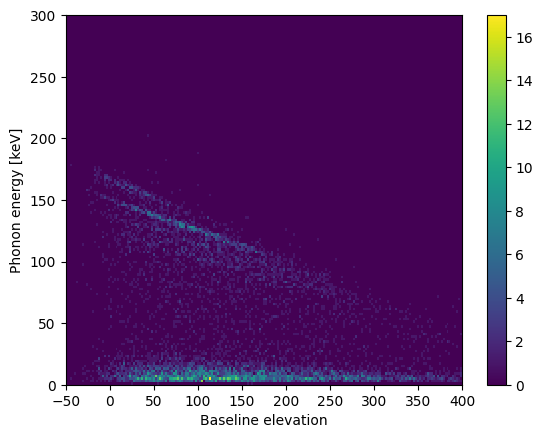

In [4]:
fig = plt.figure()
#Going to apply several data cuts in order to narrow down where we can fit to
h = plt.hist2d(z[4]["PFbs"][~z[4]["crand"]][z[4]["cphi1"]][z[4]["cam"]]-3000,z[4]["pt_keV"][~z[4]["crand"]][z[4]["cphi1"]][z[4]["cam"]]
               ,bins=[np.linspace(-50,400,200),np.linspace(0,300,150)])
plt.ylabel("Phonon energy [keV]")
plt.xlabel("Baseline elevation") #Not true yet; just the goal. 
#Based on the calculation I think this might be what I have now? But,
#Based on the plot it's very clearly not it.
fig.colorbar(h[3])
x = np.array([0,300])
#plt.plot(x,-0.232*x+150,color='r',linestyle='--')
#plt.plot([0,300],[150,75])

comment = """
pointsx = [0,0.22e-6,0.29e-6,0.38e-6] #Measured outputs, not yet known.

plt.axhline(pointsx[1],color='red',linestyle='dotted')
plt.axhline(pointsx[2],color='red',linestyle='dotted')
plt.axhline(pointsx[3],color='red',linestyle='dotted')#"""

plt.show()

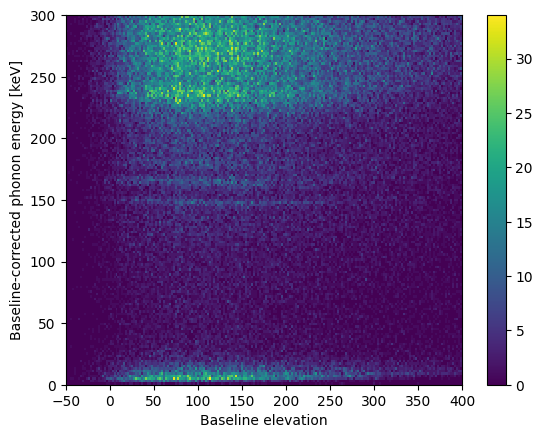

In [5]:
fig = plt.figure()
h = plt.hist2d(z[4]["PFbs"][~z[4]["crand"]]-3000,z[4]["pt_keV_bscorr"][~z[4]["crand"]]
               ,bins=[np.linspace(-50,400,200),np.linspace(0,300,150)])
plt.ylabel("Baseline-corrected phonon energy [keV]")
plt.xlabel("Baseline elevation") #Not true yet; just the goal. 
#Based on the calculation I think this might be what I have now? But,
#Based on the plot it's very clearly not it.
fig.colorbar(h[3])

comment = """
pointsx = [0,0.22e-6,0.29e-6,0.38e-6] #Measured outputs, not yet known.

plt.axhline(pointsx[1],color='red',linestyle='dotted')
plt.axhline(pointsx[2],color='red',linestyle='dotted')
plt.axhline(pointsx[3],color='red',linestyle='dotted')#"""

plt.show()

# An Automatic Fit

Below we will attempt to get this baseline correction automatically by fitting.

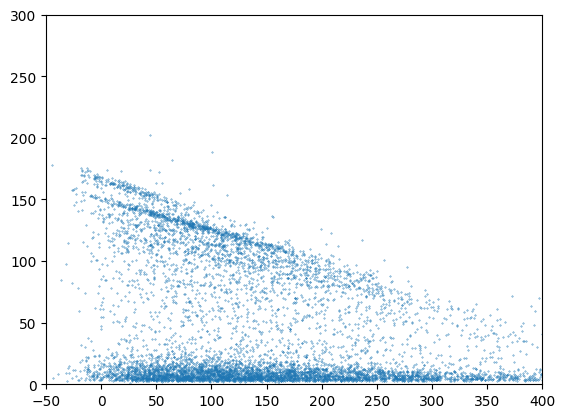

In [6]:
errors = np.sqrt(h[0]) #Get errors -- still sqrt(n)

def f(x,m=mman,b=bman): #function for a line
    return m*x+b

#No reason I can't do this as a scatter plot, right? will be easier to fit if I treat it that way.
plt.scatter(z[4]["PFbs"][~z[4]["crand"]][z[4]["cphi1"]][z[4]["cam"]]-3000,z[4]["pt_keV"][~z[4]["crand"]][z[4]["cphi1"]][z[4]["cam"]],s=0.1)
plt.xlim(-50,400)
plt.ylim(0,300)
plt.show()

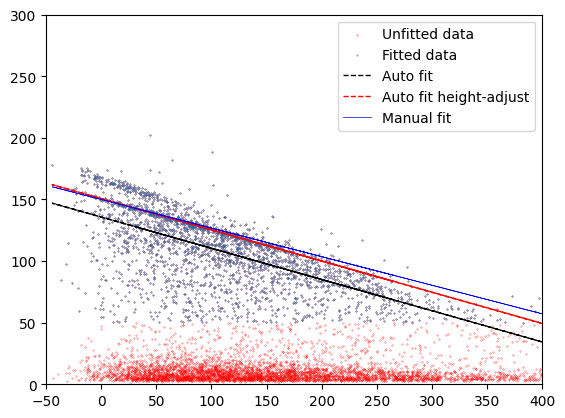

In [7]:
#Basic fit -- I expect issues with this due to many data points being the wrong region.

x = z[4]["PFbs"][~z[4]["crand"] & z[4]["cphi1"] & z[4]["cam"] & (z[4]["pt_keV"]>50)]-3000
y = z[4]["pt_keV"][~z[4]["crand"] & z[4]["cphi1"] & z[4]["cam"]  & (z[4]["pt_keV"]>50)] #cutting out all the "noise" at the bottom.
#y=y[(x>0) & (x<200)];x = x[(x>0) & (x<200)] #cut off both at the end of the line

mod = lf.Model(f)
params = mod.make_params()
params.add('m',value=-0.232,max=0,min=-1); params.add('b',value=150,min=0,max=1000)
fit = mod.fit(y,params,x=x,method='basinhop') #might be the best method for this data? not seeing singificant differences anymore
#Is this okay? It's fitting to the wrong y-intercept but all I want is the slope...

plt.scatter(z[4]["PFbs"][~z[4]["crand"] & z[4]["cphi1"] & z[4]["cam"]]-3000,z[4]["pt_keV"][~z[4]["crand"] & z[4]["cphi1"] & z[4]["cam"]],s=0.05,color='r',label='Unfitted data')
plt.scatter(x,y,s=0.1,label='Fitted data')

plt.plot(x,fit.best_fit,linestyle='--',color='k',linewidth=1,label="Auto fit")
plt.plot(x,fit.best_fit+15,linestyle='--',color='r',linewidth=1,label="Auto fit height-adjust")
plt.plot(x,f(x,m=mman,b=bman),color='b',linewidth=0.5,label="Manual fit")

plt.xlim(-50,400)
plt.ylim(0,300)#,200)
plt.legend()
plt.show()

fit

In [8]:
#For figuring out more cuts I can do
print(z[0].keys())

Index(['DetType', 'Empty', 'PAINTall', 'PAOFamps', 'PAOFamps0', 'PAOFchisq',
       'PAOFchisqLF', 'PAOFdelay', 'PATFPamp', 'PATFPchisq',
       ...
       'PTwid', 'PTdbs', 'PTINTall_PTbscorr', 'pt_keV', 'pt_keV_bscorr', 'cam',
       'xdel', 'ydel', 'phidel', 'cphi1'],
      dtype='object', length=312)


In [9]:
for x in z:
    x['new_bscorr'] = x['pt_keV']/(1.+fit.best_values['m']*(x['PFbs']-3000.)/fit.best_values['b']) #baseline correction

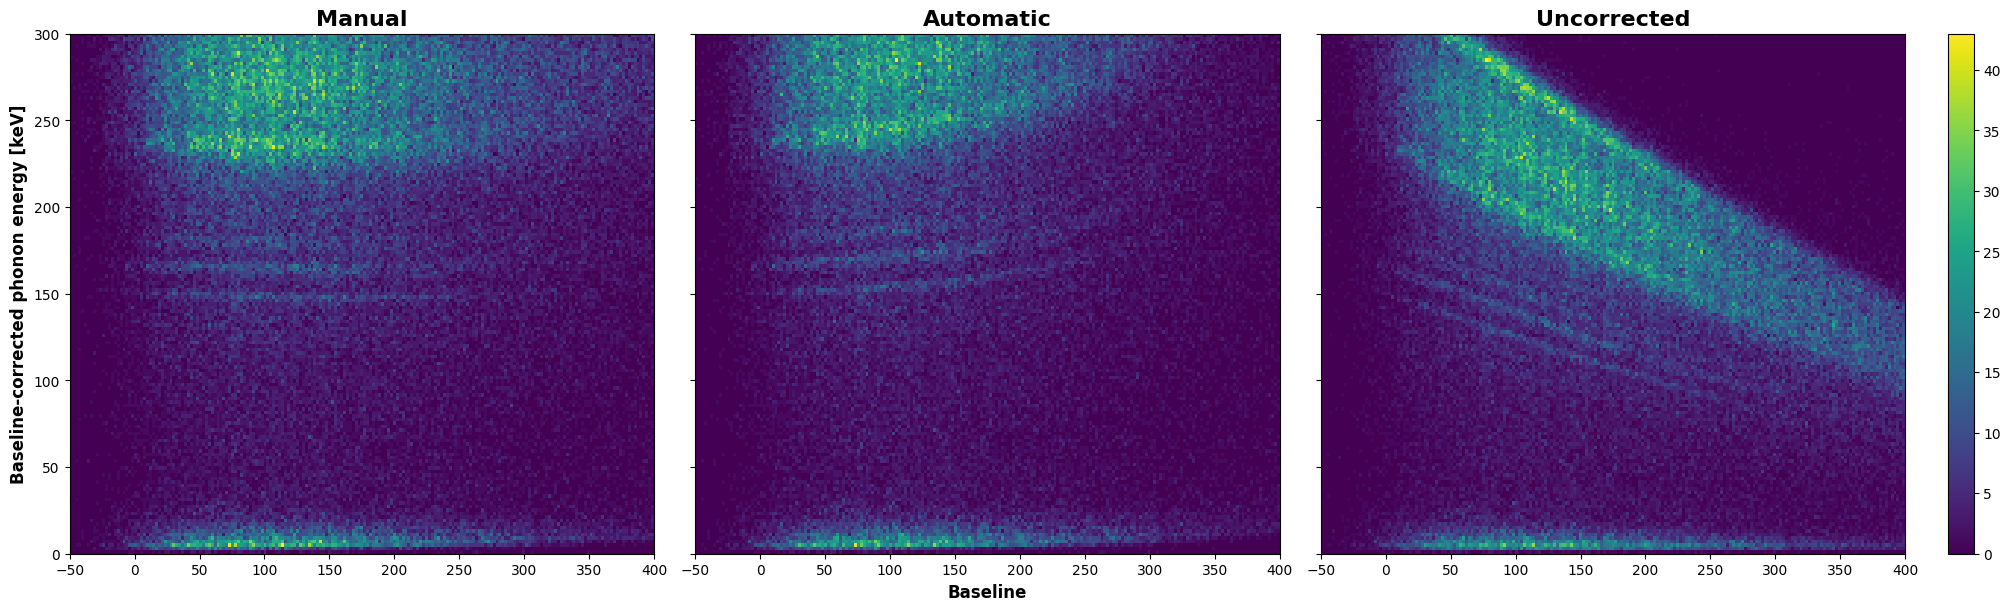

In [10]:
fig,axs = plt.subplots(1,3,figsize=(20,6),constrained_layout=True,sharey=True)
ax = axs[0]; ax2 = axs[1]; ax3 = axs[2]
h = ax.hist2d(z[4]["PFbs"][~z[4]["crand"]]-3000,z[4]["pt_keV_bscorr"][~z[4]["crand"]]
               ,bins=[np.linspace(-50,400,200),np.linspace(0,300,150)])
ax.set_ylabel("Baseline-corrected phonon energy [keV]",weight='bold',fontsize=12)
#ax2 = fig.add_subplot(1,3,2)
h = ax2.hist2d(z[4]["PFbs"][~z[4]["crand"]]-3000,z[4]["new_bscorr"][~z[4]["crand"]]
               ,bins=[np.linspace(-50,400,200),np.linspace(0,300,150)])
#ax3 = fig.add_subplot(1,3,3)
h = ax3.hist2d(z[4]["PFbs"][~z[4]["crand"]]-3000,z[4]["pt_keV"][~z[4]["crand"]]
               ,bins=[np.linspace(-50,400,200),np.linspace(0,300,150)])
ax2.set_xlabel("Baseline",weight='bold',fontsize=12)
#Based on the calculation I think this might be what I have now? But,
#Based on the plot it's very clearly not it.
fig.colorbar(h[3])

ax.set_title("Manual",weight='bold',size=16)
ax2.set_title("Automatic",weight='bold',size=16)
ax3.set_title("Uncorrected",weight='bold',size=16)

comment = """
pointsx = [0,0.22e-6,0.29e-6,0.38e-6] #Measured outputs, not yet known.

plt.axhline(pointsx[1],color='red',linestyle='dotted')
plt.axhline(pointsx[2],color='red',linestyle='dotted')
plt.axhline(pointsx[3],color='red',linestyle='dotted')#"""

plt.show()

# Current Ideas

* More cuts? Don't have any idea how to do more cuts.
* Different fitting method? I have tried those provided by lmfit and this gives the best results
* Further constraints on parameters? I don't want to over-constrain the parameters because this needs to be robust enough to work on a new data set.
* Set y-intercept first? Not sure how to do this but it may help get a better slope.

Let's experiment with the y-intercept idea:

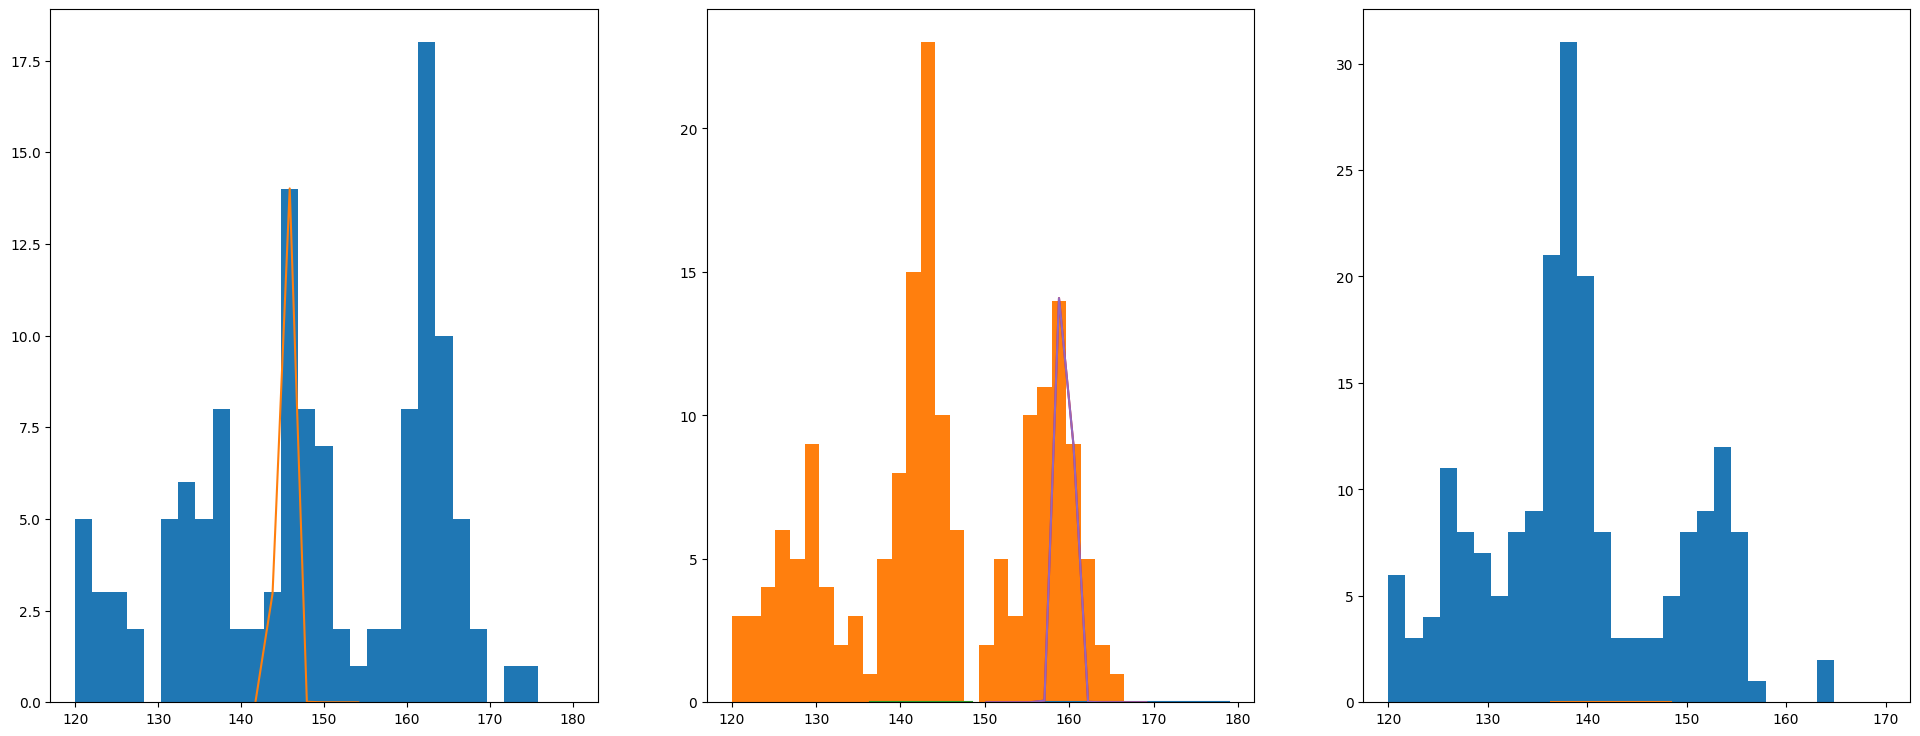

In [54]:
fig,ax = plt.subplots(1,3,figsize=(24,9))

def gaussian(x,mu,sigma):
    return 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-(x-mu)**2)
mod = lf.Model(gaussian)
params = mod.make_params()
params.add('mu',value=150); params.add('sigma',value=5)

x = z[4]["PFbs"][~z[4]["crand"] & z[4]["cphi1"] & z[4]["cam"] & (z[4]["pt_keV"]>50)]-3000
y = z[4]["pt_keV"][~z[4]["crand"] & z[4]["cphi1"] & z[4]["cam"]  & (z[4]["pt_keV"]>50)] #cutting out all the "noise" at the bottom.

bins = np.linspace(120,180,30)
h0 = ax[0].hist(y[(x<20) & (x>0)],bins=bins); h0y = h0[0]; h0x = h0[1]
h0x = (h0x[:-1] + h0x[1:])/2
fit1l = mod.fit(h0y[(h0x<155) & (h0x>140)],params,x=h0x[(h0x<155) & (h0x>140)])
fit1r = mod.fit(h0y[h0x>155],params,x=h0x[h0x>155])
ax[0].plot(h0x[(h0x<155) & (h0x>140)],fit1l.best_fit); ax[1].plot(h0x[h0x>155],fit1r.best_fit)

bins = np.linspace(120,170,30)
low = 20; high = 40
h1 = ax[1].hist(y[(x<high) & (x>low)],bins=bins); h1y = h1[0]; h1x = h1[1]
h1x = (h1x[:-1] + h1x[1:])/2
fit2l = mod.fit(h1y[(h1x<150) & (h1x>135)],params,x=h1x[(h1x<150) & (h1x>135)])
fit2r = mod.fit(h1y[h1x>150],params,x=h1x[h1x>150])
ax[1].plot(h1x[(h1x<150) & (h1x>135)],fit2l.best_fit); ax[1].plot(h1x[h1x>150],fit2r.best_fit)
#ax[1].axvline(np.mean(y[(x<high) & (x>low)]),color='k')
#ax[1].axvline(fit.best_values['b'],color='k',linestyle='--')

bins = np.linspace(120,170,30)
low = 40; high = 60
h2 = ax[2].hist(y[(x<high) & (x>low)],bins=bins); h2y = h2[0]; h2x = h2[1]
h2x = (h2x[:-1] + h2x[1:])/2
fit3l = mod.fit(h2y[(h2x<150) & (h1x>135)],params,x=h2x[(h2x<150) & (h2x>135)])
fit3r = mod.fit(h2y[h2x>150],params,x=h2x[h2x>150])
ax[2].plot(h2x[(h2x<150) & (h2x>135)],fit2l.best_fit); ax[1].plot(h2x[h2x>150],fit2r.best_fit)

plt.show()

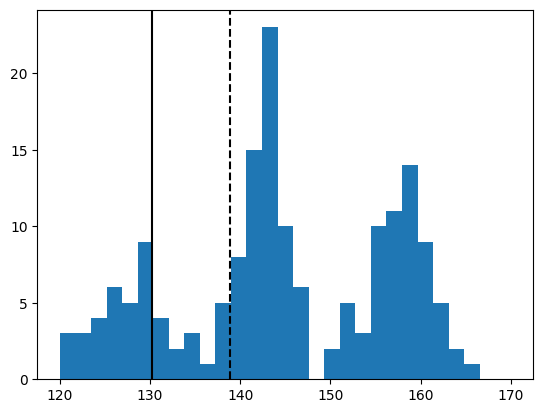

In [22]:
x = z[4]["PFbs"][~z[4]["crand"] & z[4]["cphi1"] & z[4]["cam"] & (z[4]["pt_keV"]>50)]-3000
y = z[4]["pt_keV"][~z[4]["crand"] & z[4]["cphi1"] & z[4]["cam"]  & (z[4]["pt_keV"]>50)] #cutting out all the "noise" at the bottom.



So it seems like it *is* actually choosing the mean for the intercept, roughly? It's being pulled slightly downward. What if I set the mean as the minimum?

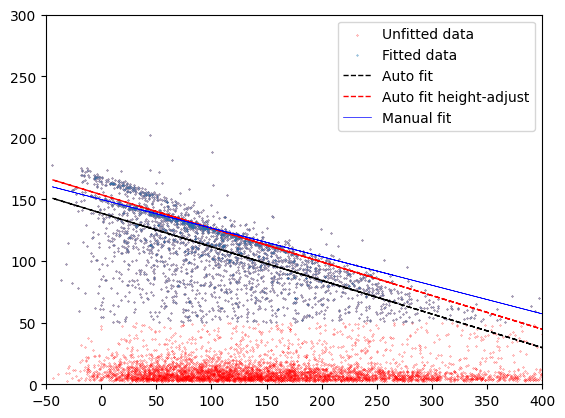

In [38]:
#Basic fit -- I expect issues with this due to many data points being the wrong region.

x = z[4]["PFbs"][~z[4]["crand"] & z[4]["cphi1"] & z[4]["cam"] & (z[4]["pt_keV"]>50)]-3000
y = z[4]["pt_keV"][~z[4]["crand"] & z[4]["cphi1"] & z[4]["cam"]  & (z[4]["pt_keV"]>50)] #cutting out all the "noise" at the bottom.
#y=y[(x>0) & (x<200)];x = x[(x>0) & (x<200)] #cut off both at the end of the line

mod = lf.Model(f)
params = mod.make_params()
params.add('m',value=-0.232,max=0,min=-1); params.add('b',value=150,min=np.mean(y[(x<5) & (y>-5)]),max=1000)
fit = mod.fit(y,params,x=x,method='basinhop') #might be the best method for this data? not seeing singificant differences anymore
#Is this okay? It's fitting to the wrong y-intercept but all I want is the slope...

plt.scatter(z[4]["PFbs"][~z[4]["crand"] & z[4]["cphi1"] & z[4]["cam"]]-3000,z[4]["pt_keV"][~z[4]["crand"] & z[4]["cphi1"] & z[4]["cam"]],s=0.05,color='r',label='Unfitted data')
plt.scatter(x,y,s=0.1,label='Fitted data')

plt.plot(x,fit.best_fit,linestyle='--',color='k',linewidth=1,label="Auto fit")
plt.plot(x,fit.best_fit+15,linestyle='--',color='r',linewidth=1,label="Auto fit height-adjust")
plt.plot(x,f(x,m=mman,b=bman),color='b',linewidth=0.5,label="Manual fit")

plt.xlim(-50,400)
plt.ylim(0,300)#,200)
plt.legend()
plt.show()

fit

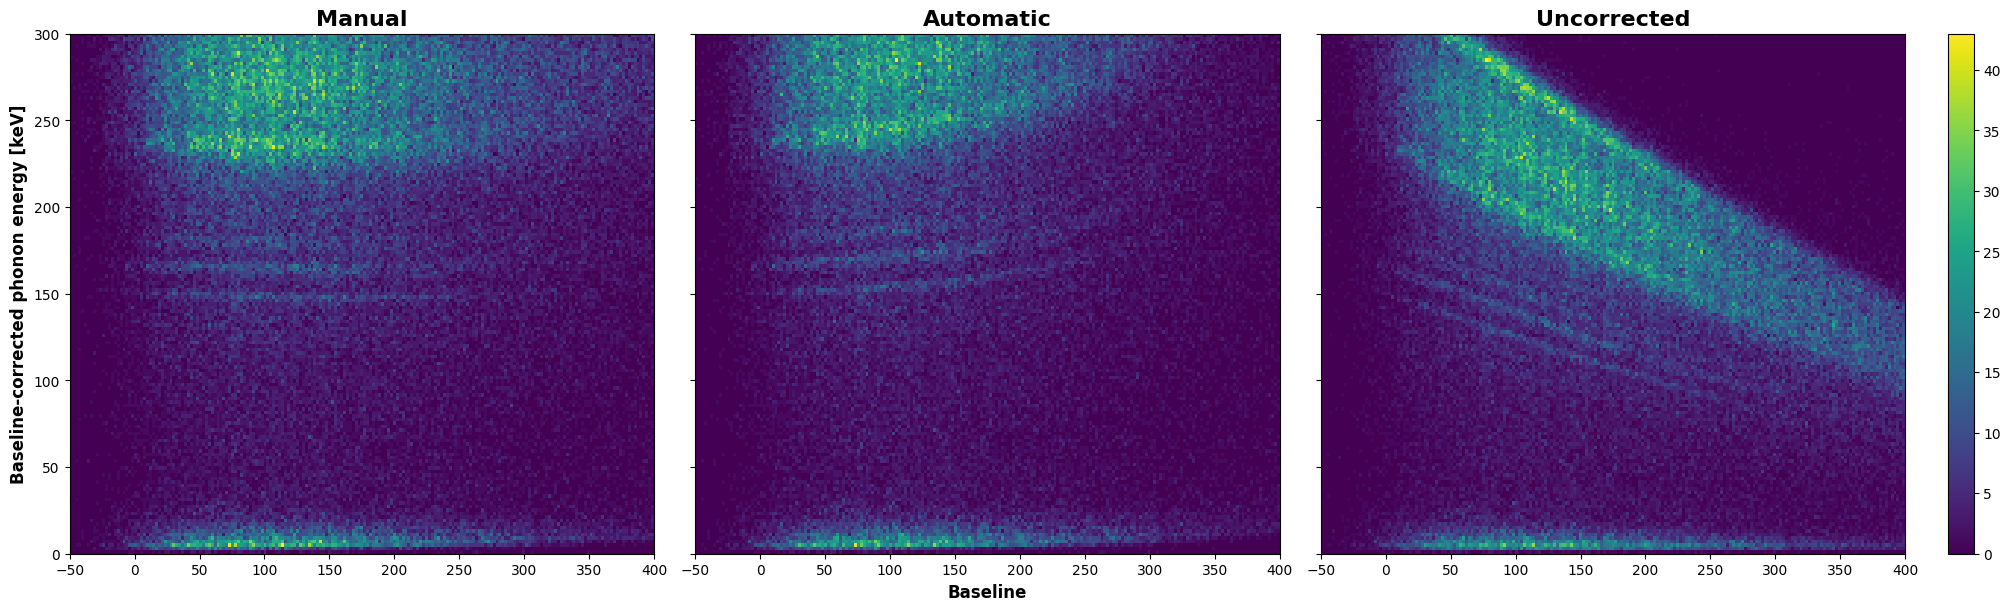

In [13]:
fig,axs = plt.subplots(1,3,figsize=(20,6),constrained_layout=True,sharey=True)
ax = axs[0]; ax2 = axs[1]; ax3 = axs[2]
h = ax.hist2d(z[4]["PFbs"][~z[4]["crand"]]-3000,z[4]["pt_keV_bscorr"][~z[4]["crand"]]
               ,bins=[np.linspace(-50,400,200),np.linspace(0,300,150)])
ax.set_ylabel("Baseline-corrected phonon energy [keV]",weight='bold',fontsize=12)
#ax2 = fig.add_subplot(1,3,2)
h = ax2.hist2d(z[4]["PFbs"][~z[4]["crand"]]-3000,z[4]["new_bscorr"][~z[4]["crand"]]
               ,bins=[np.linspace(-50,400,200),np.linspace(0,300,150)])
#ax3 = fig.add_subplot(1,3,3)
h = ax3.hist2d(z[4]["PFbs"][~z[4]["crand"]]-3000,z[4]["pt_keV"][~z[4]["crand"]]
               ,bins=[np.linspace(-50,400,200),np.linspace(0,300,150)])
ax2.set_xlabel("Baseline",weight='bold',fontsize=12)
#Based on the calculation I think this might be what I have now? But,
#Based on the plot it's very clearly not it.
fig.colorbar(h[3])

ax.set_title("Manual",weight='bold',size=16)
ax2.set_title("Automatic",weight='bold',size=16)
ax3.set_title("Uncorrected",weight='bold',size=16)

comment = """
pointsx = [0,0.22e-6,0.29e-6,0.38e-6] #Measured outputs, not yet known.

plt.axhline(pointsx[1],color='red',linestyle='dotted')
plt.axhline(pointsx[2],color='red',linestyle='dotted')
plt.axhline(pointsx[3],color='red',linestyle='dotted')#"""

plt.show()

The intercept is more correct, but the slope, which we actually care about, is worse. Is there some way we can use this kind of method to remove noise?